# PGF5005 — Hénon–Heiles · **Itens 5.3 e 5.4 (v3 corrigido)**  
Seções de Poincaré em energias fixas com escolhas de ICs estáveis

**Mudanças principais**
- ICs na seção \(\Sigma:\ q_1=0\) com **\(p_1 \approx 0\)** (mínimo para cruzar) e **\(p_2\)** calculado da energia:
  \[ p_2(q_2;E) = \sqrt{\,2E - q_2^2 + \tfrac{2}{3}q_2^3 - p_1^2\,}.\]
  Isso evita valores imensos de \(p_1\) e mantém a dinâmica no poço de potencial.
- Cruzamentos \(q_1=0\) por **interpolação linear**.
- Parada por **número de interseções** por IC.


## 1) Modelo e passo Euler simplético

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def H(q1,q2,p1,p2):
    return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2

def euler_symplectic_step(q1,q2,p1,p2, dt):
    q1n = q1 + dt*p1
    q2n = q2 + dt*p2
    dU1 = q1n + 2.0*q1n*q2n
    dU2 = q2n + q1n*q1n - q2n*q2n
    p1n = p1 - dt*dU1
    p2n = p2 - dt*dU2
    return q1n,q2n,p1n,p2n


## 2) Seção de Hénon: cruzamento robusto

In [2]:
def henon_section_q1_zero_stream(q1,q2,p1,p2, dt, max_points=800, T_max=6000.0, blowup=10.0):
    pts_q2, pts_p2 = [], []
    t = 0.0
    q1n,q2n,p1n,p2n = q1,q2,p1,p2
    while t < T_max and len(pts_q2) < max_points:
        q1m,q2m,p1m,p2m = euler_symplectic_step(q1n,q2n,p1n,p2n, dt)
        if q1n*q1m < 0.0:
            s = q1n / (q1n - q1m)
            q2_star = q2n + s*(q2m - q2n)
            p1_star = p1n + s*(p1m - p1n)
            p2_star = p2n + s*(p2m - p2n)
            if p1_star >= 0.0:
                pts_q2.append(q2_star); pts_p2.append(p2_star)
        q1n,q2n,p1n,p2n = q1m,q2m,p1m,p2m
        t += dt
        # corta estados que escaparam do poço (escala típica do HH <~ 2)
        if max(abs(q1n),abs(q2n),abs(p1n),abs(p2n)) > blowup:
            break
    return np.array(pts_q2), np.array(pts_p2)


## 3) ICs sobre a seção com \(p_1\approx0\) e \(p_2\) da energia

In [3]:
def allowed_q2_for_p2(E, p1=0.0, n_samples=2000):
    q2_grid = np.linspace(-0.6, 1.2, n_samples)  # janela física típica do HH < escape
    rad = 2*E - q2_grid**2 + (2.0/3.0)*q2_grid**3 - p1**2
    return q2_grid[rad >= 0.0]

def p2_from_energy(E, q2, p1=0.0):
    rad = max(0.0, 2*E - q2*q2 + (2.0/3.0)*q2*q2*q2 - p1*p1)
    return math.sqrt(rad)


## 4) Construção da seção para um \(E\) (eficiente)

In [4]:
def poincare_section_energy(E, dt=5e-4, N_per_ic=500, T_max=6000.0, n_ic=28, p1_ic=0.0):
    q2_allowed = allowed_q2_for_p2(E, p1=p1_ic)
    if len(q2_allowed)==0:
        return np.array([]), np.array([])
    idx = np.linspace(0, len(q2_allowed)-1, n_ic).astype(int)
    q2_ics = q2_allowed[idx]
    all_q2, all_p2 = [], []
    for q2_0 in q2_ics:
        p2_0 = p2_from_energy(E, q2_0, p1=p1_ic)
        q2_pts, p2_pts = henon_section_q1_zero_stream(0.0, q2_0, p1_ic, p2_0,
                                                      dt, max_points=N_per_ic, T_max=T_max)
        if len(q2_pts):
            all_q2.append(q2_pts); all_p2.append(p2_pts)
    if not all_q2:
        return np.array([]), np.array([])
    return np.concatenate(all_q2), np.concatenate(all_p2)

def plot_section(q2_pts, p2_pts, E, save=None):
    plt.figure()
    plt.plot(q2_pts, p2_pts, '.', ms=1.2)
    plt.xlabel('q2 (na seção q1=0)')
    plt.ylabel('p2 (na seção q1=0)')
    plt.title(f'Secção de Poincaré (p2 × q2) — Hénon–Heiles — E={E:.5f}')
    if save:
        plt.savefig(save, dpi=240, bbox_inches='tight')
    plt.show()


## 5) Executar para **E=0.08333** e **E=0.125**

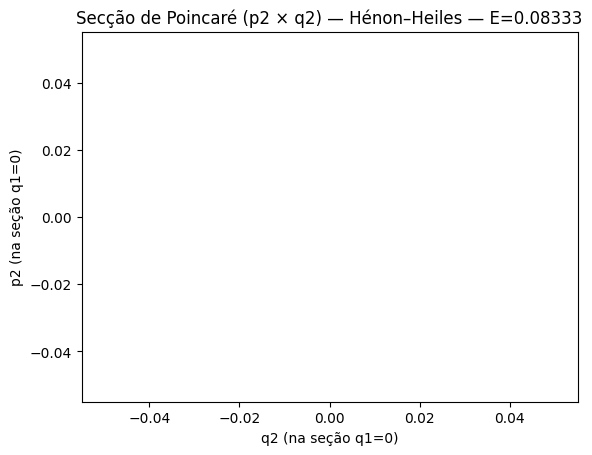

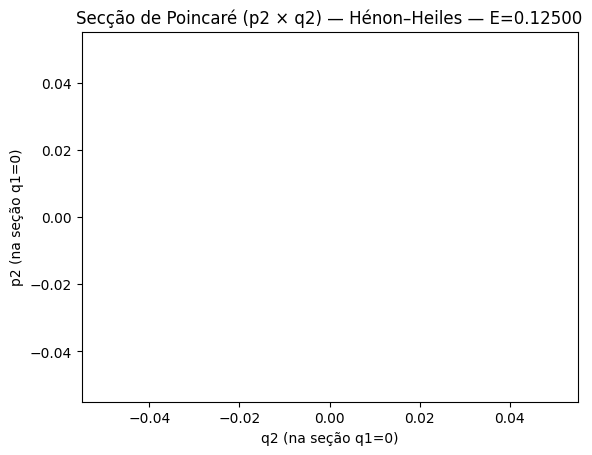

In [5]:
E1, E2 = 0.08333, 0.12500
dt = 5e-4
N_per_ic = 600
T_max = 6000.0
n_ic = 30
p1_ic = 0.0  # define p1 ~ 0 na seção; p2 vem da energia

q2_1, p2_1 = poincare_section_energy(E1, dt=dt, N_per_ic=N_per_ic, T_max=T_max, n_ic=n_ic, p1_ic=p1_ic)
plot_section(q2_1, p2_1, E1)

q2_2, p2_2 = poincare_section_energy(E2, dt=dt, N_per_ic=N_per_ic, T_max=T_max, n_ic=n_ic, p1_ic=p1_ic)
plot_section(q2_2, p2_2, E2)
